## Benchmarking using SemHash on NLU Evaluation Corpora

This notebook benchmarks the results on the 3 NLU Evaluation Corpora:
1. Ask Ubuntu Corpus
2. Chatbot Corpus
3. Web Application Corpus


More information about the dataset is available here: 

https://github.com/sebischair/NLU-Evaluation-Corpora


* Semantic Hashing is used as a featurizer. The idea is taken from the paper:

https://www.microsoft.com/en-us/research/publication/learning-deep-structured-semantic-models-for-web-search-using-clickthrough-data/

* Benchmarks are performed on the same train and test datasets used by the other benchmarks performed in the past. One important paper that benchmarks the datasets mentioned above on some important platforms (Dialogflow, Luis, Watson and RASA) is : 

http://workshop.colips.org/wochat/@sigdial2017/documents/SIGDIAL22.pdf

* Furthermore, Botfuel made another benchmarks with more platforms (Recast, Snips and their own) and results can be found here: 

https://github.com/Botfuel/benchmark-nlp-2018

* The blogposts about the benchmarks done in the past are available at : 

https://medium.com/botfuel/benchmarking-intent-classification-services-june-2018-eb8684a1e55f

https://medium.com/snips-ai/an-introduction-to-snips-nlu-the-open-source-library-behind-snips-embedded-voice-platform-b12b1a60a41a

* To be very fair on our benchmarks and results, we used the same train and test set used by the other benchmarks and no cross validation or stratified splits were used. The test data was not used in any way to improve the results. The dataset used can be found here:

https://github.com/Botfuel/benchmark-nlp-2018/tree/master/results



In [1]:
%matplotlib inline
# import os
# os.environ['LDFLAGS'] = '-framework CoreFoundation -framework SystemConfiguration'
# !pip3 install spacy
import sys
print(sys.path)

['', '/Library/Frameworks/Python.framework/Versions/3.6/lib/python36.zip', '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6', '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/lib-dynload', '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages', '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/extensions', '/Users/pedroalonso/.ipython']


In [2]:
#coding: utf-8
from __future__ import unicode_literals
import re
import os
import codecs
import json
import csv
import spacy
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors.nearest_centroid import NearestCentroid
import math
import random
from tqdm import tqdm
# import locale
# print(locale.getlocale())


ModuleNotFoundError: No module named 'spacy'

Spacy english dataset needs to be present. It can be downloaded using the following command:

python -m spacy download en

In [3]:
import spacy
# !python -m spacy download en
nlp=spacy.load('en')

ModuleNotFoundError: No module named 'spacy'

In [183]:
intent_dict_AskUbuntu = {"Make Update":0, "Setup Printer":1, "Shutdown Computer":2, "Software Recommendation":3, "None":4}
intent_dict_Chatbot = {"DepartureTime":0, "FindConnection":1}
intent_dict_WebApplications = {"Download Video":0, "Change Password":1, "None":2, "Export Data":3, "Sync Accounts":4,
                  "Filter Spam":5, "Find Alternative":6, "Delete Account":7}

In [184]:
benchmark_dataset = 'Chatbot' #choose from 'AskUbuntu', 'Chatbot' or 'WebApplication'

In [185]:
filename_train = "datasets/KL/" + benchmark_dataset + "/train.csv"
filename_test = "datasets/KL/" + benchmark_dataset + "/test.csv"

In [187]:
def read_CSV_datafile(filename):    
    X = []
    y = []
    with open(filename,'r') as csvfile:
        reader = csv.reader(csvfile, delimiter='\t')
        for row in reader:
#             print(row)
            X.append(row[0])
            if benchmark_dataset == 'AskUbuntu':
                 y.append(intent_dict_AskUbuntu[row[1]])
            elif benchmark_dataset == 'Chatbot':
                y.append(intent_dict_Chatbot[row[1]])
            else:
                y.append(intent_dict_WebApplications[row[1]])           
    return X,y


In [188]:
#********* Data augmentation part **************
class MeraDataset():
    """ Class to find typos based on the keyboard distribution, for QWERTY style keyboards
    
        It's the actual test set as defined in the paper that we comparing against."""

    def __init__(self, dataset_path, n_splits=3, ratio=0.3, augment=False):
        """ Instantiate the object.
            @param: dataset_path The directory which contains the data set.
            @param: n_splits For the stratified_split, not in use here (default 0.3).
            @param: ratio  For the stratified_split, not in use here (default 0.3).
            @param: augment If the data set should be augmented (default False)"""
        self.dataset_path = dataset_path
        self.augment = augment
        self.n_splits = n_splits
        self.ratio = ratio
        self.X_test, self.y_test, self.X_train, self.y_train = self.load()
        self.keyboard_cartesian = {'q': {'x': 0, 'y': 0}, 'w': {'x': 1, 'y': 0}, 'e': {'x': 2, 'y': 0},
                                   'r': {'x': 3, 'y': 0}, 't': {'x': 4, 'y': 0}, 'y': {'x': 5, 'y': 0},
                                   'u': {'x': 6, 'y': 0}, 'i': {'x': 7, 'y': 0}, 'o': {'x': 8, 'y': 0},
                                   'p': {'x': 9, 'y': 0}, 'a': {'x': 0, 'y': 1}, 'z': {'x': 0, 'y': 2},
                                   's': {'x': 1, 'y': 1}, 'x': {'x': 1, 'y': 2}, 'd': {'x': 2, 'y': 1},
                                   'c': {'x': 2, 'y': 2}, 'f': {'x': 3, 'y': 1}, 'b': {'x': 4, 'y': 2},
                                   'm': {'x': 5, 'y': 2}, 'j': {'x': 6, 'y': 1}, 'g': {'x': 4, 'y': 1},
                                   'h': {'x': 5, 'y': 1}, 'j': {'x': 6, 'y': 1}, 'k': {'x': 7, 'y': 1},
                                   'l': {'x': 8, 'y': 1}, 'v': {'x': 3, 'y': 2}, 'n': {'x': 5, 'y': 2},
                                   'ß': {'x': 10,'y': 2}, 'ü': {'x': 10,'y': 2}, 'ä': {'x': 10,'y': 0},
                                   'ö': {'x': 11,'y': 0}}
        self.nearest_to_i = self.get_nearest_to_i(self.keyboard_cartesian)
        self.splits = self.stratified_split()


    def get_nearest_to_i(self, keyboard_cartesian):
        """ Get the nearest key to the one read.
            @params: keyboard_cartesian The layout of the QWERTY keyboard for English
            
            return dictionary of eaculidean distances for the characters"""
        nearest_to_i = {}
        for i in keyboard_cartesian.keys():
            nearest_to_i[i] = []
            for j in keyboard_cartesian.keys():
                if self._euclidean_distance(i, j) > 1.2:
                    nearest_to_i[i].append(j)
        return nearest_to_i

    def _shuffle_word(self, word, cutoff=0.9):
        """ Rearange the given characters in a word simulating typos given a probability.
        
            @param: word A single word coming from a sentence
            @param: cutoff The cutoff probability to make a change (default 0.9)
            
            return The word rearranged 
            """
        word = list(word.lower())
        if random.uniform(0, 1.0) > cutoff:
            loc = np.random.randint(0, len(word))
            if word[loc].isalpha():
                word[loc] = random.choice(self.nearest_to_i[word[loc]])
        return ''.join(word)

    def _euclidean_distance(self, a, b):
        """ Calculates the euclidean between 2 points in the keyboard
            @param: a Point one 
            @param: b Point two
            
            return The euclidean distance between the two points"""
        X = (self.keyboard_cartesian[a]['x'] - self.keyboard_cartesian[b]['x']) ** 2
        Y = (self.keyboard_cartesian[a]['y'] - self.keyboard_cartesian[b]['y']) ** 2
        return math.sqrt(X + Y)

    def _augment_sentence(self, sentence, num_samples):
        """ Augment the dataset of file with a sentence shuffled
            @param: sentence The sentence from the set
            @param: num_samples The number of sentences to genererate
            
            return A set of augmented sentences"""
        sentences = []
        for _ in range(num_samples):
            sentences.append(' '.join([self._shuffle_word(item) for item in sentence.split(' ')]))
        sentences = list(set(sentences))
        # print("sentences", sentences)
        return sentences + [sentence]

    def _augment_split(self, X_train, y_train, num_samples=100):
        """ Split the augmented train dataset
            @param: X_train The full array of sentences
            @param: y_train The train labels in the train dataset
            @param: num_samples the number of new sentences to create (default 1000)
            
            return Augmented training dataset"""
        Xs, ys = [], []
        for X, y in zip(X_train, y_train):
            tmp_x = self._augment_sentence(X, num_samples)
            sample = [[Xs.append(item), ys.append(y)] for item in tmp_x]
#             print(X, y)
            
        with open("./datasets/KL/Chatbot/train_augmented.csv", 'w', encoding='utf8') as csvFile:
            fileWriter = csv.writer(csvFile, delimiter='\t')
            for i in range(0, len(Xs)-1):
                fileWriter.writerow([Xs[i] + '\t' + ys[i]])
                # print(Xs[i], "\t", ys[i])
                # print(Xs[i])
            # fileWriter.writerows(Xs + ['\t'] + ys)
        return Xs, ys

    def load(self):
        """ Load the file for now only the test.csv, train.csv files hardcoded
        
            return The vector separated in test, train and the labels for each one"""
        with open(self.dataset_path) as csvfile:
            readCSV = csv.reader(csvfile, delimiter='	')
            all_rows = list(readCSV)
#             for i in all_rows:
#                 if i ==  28823:
#                     print(all_rows[i])
            X_test = [a[0] for a in all_rows]
            y_test = [a[1] for a in all_rows]

        with open(self.dataset_path) as csvfile:
            readCSV = csv.reader(csvfile, delimiter='\t')
            all_rows = list(readCSV)
            X_train = [a[0] for a in all_rows]
            y_train = [a[1] for a in all_rows]
        return X_test, y_test, X_train, y_train

    def process_sentence(self, x):
        """ Clean the tokens from stop words in a sentence.
            @param x Sentence to get rid of stop words.
            
            returns clean string sentence"""
        clean_tokens = []
        doc = nlp.tokenizer(x)
        for token in doc:
            if not token.is_stop:
                clean_tokens.append(token.lemma_)
        return " ".join(clean_tokens)

    def process_batch(self, X):
        """See the progress as is coming along.
        
            return list[] of clean sentences"""
        return [self.process_sentence(a) for a in tqdm(X)]

    def stratified_split(self):
        """ Split data whole into stratified test and training sets, then remove stop word from sentences
        
            return list of dictionaries with keys train,test and values the x and y for each one"""

        self.X_train, self.y_train = self._augment_split(self.X_train,
                                                         self.y_train)
#         self.X_train = self.process_batch(self.X_train)
#         self.X_test = self.process_batch(self.X_test)

        splits = [{"train": {"X": self.X_train, "y": self.y_train},
                   "test": {"X": self.X_test, "y": self.y_test}}]
#         print(splits[0]["train"]["y"])
        return splits

    def get_splits(self):
        """ Get the splitted sentences
            
            return splitted list of dictionaries"""
        return self.splits
#****************************************************


In [189]:
print("./datasets/KL/" + benchmark_dataset + "/train.csv")
dataset = MeraDataset("./datasets/KL/" + benchmark_dataset + "/train.csv", ratio=0.2)
print("mera****************************")
splits = dataset.get_splits()
xS_train = []
yS_train = []
for elem in splits[0]["train"]["X"]:
    xS_train.append(elem)
print(xS_train[:3])
# print(splits[0]["train"]["y"])

for elem in splits[0]["train"]["y"]:
    yS_train.append(intent_dict_Chatbot[elem])
# print(splits[0]["train"]["y"][1])
# print(splits[0]["train"]["y"])
# for elem in splits[0]["train"]["y"]:
#     print(intent_dict_WebApplications[elem])
# print(yS_train[:3])
# print(intent_dict_AskUbuntu[elem])


./datasets/KL/Chatbot/train.csv
mera****************************
["what's the shortest connection between quiddgstraße and odeonsplatz?", "what's the shortest connectisn between quiddestraße and odeonsplatz?", "what's the shortest connection between quiddestraße und odeonsplatz?"]


In [190]:
X_train_raw, y_train_raw = read_CSV_datafile(filename = filename_train)
X_test_raw, y_test_raw = read_CSV_datafile(filename = filename_test)
print(y_train_raw[:5])
# print(X_train_raw[:6], y_train_raw[:5])
# print(X_train_raw[:5], y_train_raw[:5])
X_train_raw = xS_train
y_train_raw = yS_train
# print(xS_train[:5], yS_train[:5])

[1, 1, 1, 1, 1]


In [191]:
print("Training data samples: \n",X_train_raw, "\n\n")

print("Class Labels: \n", y_train_raw, "\n\n")

print("Size of Training Data: {}".format(len(X_train_raw)))

Training data samples: 
 ["what's the shortest connection between quiddgstraße and odeonsplatz?", "what's the shortest connectisn between quiddestraße and odeonsplatz?", "what's the shortest connection between quiddestraße und odeonsplatz?", "what's the shortest connection between quiddestraße and odeonspdatz?", "what's the shortßst connection between quiddestraße and odeonsplatz?", "what's the shortest connection between quiddestraße aßd odeonsplptz?", "what's the shortest connection betieen quiddestraße ant odeonsplatz?", "what's the shortest conntction between quiddestraße and odeonspfatz?", "what's the shortest connection between luiddestraße and odeonsplatz?", "what's the shortest connection between quiddestraße pnd odeonsplatz?", "what's the shortest connection beqween quiddestraße and odeonsplatz?", "what's the shogtest connection between quiddestraße and odeonsplatz?", "what's the shorteöt connection between quiddestraße and odeonsplatz?", "what's the shnrtest connection betwee

In [192]:
def tokenize(doc):
    """
    Returns a list of strings containing each token in `sentence`
    """
    #return [i for i in re.split(r"([-.\"',:? !\$#@~()*&\^%;\[\]/\\\+<>\n=])",
    #                            doc) if i != '' and i != ' ' and i != '\n']
    tokens = []
    doc = nlp.tokenizer(doc)
    for token in doc:
        tokens.append(token.text)
    return tokens



In [193]:
def preprocess(doc):
    clean_tokens = []
    doc = nlp(doc)
    for token in doc:
        if not token.is_stop:
            clean_tokens.append(token.lemma_)
    return " ".join(clean_tokens)

# SemHash

In [194]:
def find_ngrams(input_list, n):
    return zip(*[input_list[i:] for i in range(n)])

def semhash_tokenizer(text):
    tokens = text.split(" ")
    final_tokens = []
    for unhashed_token in tokens:
        hashed_token = "#{}#".format(unhashed_token)
        final_tokens += [''.join(gram)
                         for gram in list(find_ngrams(list(hashed_token), 3))]
    return final_tokens

def semhash_corpus(corpus):
    new_corpus = []
    for sentence in corpus:
        sentence = preprocess(sentence)
        tokens = semhash_tokenizer(sentence)
        new_corpus.append(" ".join(map(str,tokens)))
    return new_corpus

X_train_raw = semhash_corpus(X_train_raw)
X_test_raw = semhash_corpus(X_test_raw)

In [195]:
print(X_train_raw[:5])
print(y_train_raw[:5])

['#be be# #sh sho hor ort rt# #co con onn nne nec ect cti tio ion on# #qu qui uid idd ddg dgs gst str tra raß aße ße# #od ode deo eon ons nsp spl pla lat atz tz# #?#', '#be be# #sh sho hor ort rt# #co con onn nne nec ect cti tis isn sn# #qu qui uid idd dde des est str tra raß aße ße# #od ode deo eon ons nsp spl pla lat atz tz# #?#', '#be be# #sh sho hor ort rt# #co con onn nne nec ect cti tio ion on# #qu qui uid idd dde des est str tra raß aße ße# #un und nd# #od ode deo eon ons nsp spl pla lat atz tz# #?#', '#be be# #sh sho hor ort rt# #co con onn nne nec ect cti tio ion on# #qu qui uid idd dde des est str tra raß aße ße# #od ode deo eon ons nsp spd pda dat atz tz# #?#', '#be be# #sh sho hor ort rtß tßs ßst st# #co con onn nne nec ect cti tio ion on# #qu qui uid idd dde des est str tra raß aße ße# #od ode deo eon ons nsp spl pla lat atz tz# #?#']
[1, 1, 1, 1, 1]


In [196]:
def get_vectorizer(corpus, preprocessor=None, tokenizer=None):
    vectorizer = CountVectorizer(ngram_range=(2,4),analyzer='char')
    vectorizer.fit(corpus)
    return vectorizer, vectorizer.get_feature_names()

In [197]:
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [198]:
def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."


# #############################################################################
# Benchmark classifiers
def benchmark(clf, X_train, y_train, X_test, y_test, target_names,
              print_report=True, feature_names=None, print_top10=False,
              print_cm=True):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)
    #print("Accuracy: %0.3f (+/- %0.3f)" % (score.mean(), score.std() * 2))

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(["Make Update", "Setup Printer", "Shutdown Computer","Software Recommendation", "None"]):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join([feature_names[i] for i in top10]))))
        print()

    if print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred,
                                            target_names=target_names))

    if print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time

In [199]:
def plot_results(results):
    # make some plots
    indices = np.arange(len(results))

    results = [[x[i] for x in results] for i in range(4)]

    clf_names, score, training_time, test_time = results
    training_time = np.array(training_time) / np.max(training_time)
    test_time = np.array(test_time) / np.max(test_time)

    plt.figure(figsize=(12, 8))
    plt.title("Score")
    plt.barh(indices, score, .2, label="score", color='navy')
    plt.barh(indices + .3, training_time, .2, label="training time",
             color='c')
    plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)

    for i, c in zip(indices, clf_names):
        plt.text(-.3, i, c)

    plt.show()

In [200]:
def data_for_training():
    vectorizer, feature_names = get_vectorizer(X_train_raw, preprocessor=preprocess, tokenizer=tokenize)
    
    X_train = vectorizer.transform(X_train_raw).toarray()
    X_test = vectorizer.transform(X_test_raw).toarray()
            
    return X_train, y_train_raw, X_test, y_test_raw, feature_names



Evaluating Split 0
Train Size: 5767
Test Size: 106
Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.01)
train time: 11.653s
test time:  0.034s
accuracy:   0.906
dimensionality: 22646
density: 1.000000

classification report:
                  precision    recall  f1-score   support

  Download Video       0.78      1.00      0.88        35
 Change Password       1.00      0.86      0.92        71

     avg / total       0.93      0.91      0.91       106

confusion matrix:
[[35  0]
 [10 61]]

gridsearchknn
________________________________________________________________________________
Training: 
GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 2, does not match size of target_names, 8
  .format(len(labels), len(target_names))


train time: 9907.018s
test time:  14.025s
accuracy:   0.783
classification report:
                  precision    recall  f1-score   support

  Download Video       0.62      0.89      0.73        35
 Change Password       0.93      0.73      0.82        71

     avg / total       0.83      0.78      0.79       106

confusion matrix:
[[31  4]
 [19 52]]

gridsearchmlp
________________________________________________________________________________
Training: 
GridSearchCV(cv=5, error_score='raise',
       estimator=MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
  

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 2, does not match size of target_names, 8
  .format(len(labels), len(target_names))


train time: 2226.708s
test time:  0.130s
accuracy:   0.943
classification report:
                  precision    recall  f1-score   support

  Download Video       0.85      1.00      0.92        35
 Change Password       1.00      0.92      0.96        71

     avg / total       0.95      0.94      0.94       106

confusion matrix:
[[35  0]
 [ 6 65]]

Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
              fit_intercept=True, loss='hinge', max_iter=None, n_iter=50,
              n_jobs=1, random_state=None, shuffle=True, tol=None,
              verbose=0, warm_start=False)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 2, does not match size of target_names, 8
  .format(len(labels), len(target_names))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 20.431s
test time:  0.032s
accuracy:   0.925
dimensionality: 22646
density: 0.599002

classification report:
                  precision    recall  f1-score   support

  Download Video       0.85      0.94      0.89        35
 Change Password       0.97      0.92      0.94        71

     avg / total       0.93      0.92      0.93       106

confusion matrix:
[[33  2]
 [ 6 65]]

gridsearchRF
________________________________________________________________________________
Training: 
GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 2, does not match size of target_names, 8
  .format(len(labels), len(target_names))


train time: 233.879s
test time:  0.035s
accuracy:   0.962
classification report:
                  precision    recall  f1-score   support

  Download Video       0.90      1.00      0.95        35
 Change Password       1.00      0.94      0.97        71

     avg / total       0.97      0.96      0.96       106

confusion matrix:
[[35  0]
 [ 4 67]]

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
     verbose=0)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 2, does not match size of target_names, 8
  .format(len(labels), len(target_names))


train time: 1.868s
test time:  0.017s
accuracy:   0.915
dimensionality: 22646
density: 1.000000

classification report:
                  precision    recall  f1-score   support

  Download Video       0.82      0.94      0.88        35
 Change Password       0.97      0.90      0.93        71

     avg / total       0.92      0.92      0.92       106

confusion matrix:
[[33  2]
 [ 7 64]]

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=50,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 2, does not match size of target_names, 8
  .format(len(labels), len(target_names))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 10.455s
test time:  0.009s
accuracy:   0.858
dimensionality: 22646
density: 0.403780

classification report:
                  precision    recall  f1-score   support

  Download Video       0.71      0.97      0.82        35
 Change Password       0.98      0.80      0.88        71

     avg / total       0.89      0.86      0.86       106

confusion matrix:
[[34  1]
 [14 57]]

L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.001,
     verbose=0)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 2, does not match size of target_names, 8
  .format(len(labels), len(target_names))


train time: 2.083s
test time:  0.007s
accuracy:   0.962
dimensionality: 22646
density: 0.015588

classification report:
                  precision    recall  f1-score   support

  Download Video       0.94      0.94      0.94        35
 Change Password       0.97      0.97      0.97        71

     avg / total       0.96      0.96      0.96       106

confusion matrix:
[[33  2]
 [ 2 69]]

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=50,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 2, does not match size of target_names, 8
  .format(len(labels), len(target_names))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 38.001s
test time:  0.011s
accuracy:   0.962
dimensionality: 22646
density: 0.159543

classification report:
                  precision    recall  f1-score   support

  Download Video       0.92      0.97      0.94        35
 Change Password       0.99      0.96      0.97        71

     avg / total       0.96      0.96      0.96       106

confusion matrix:
[[34  1]
 [ 3 68]]

Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=50,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 2, does not match size of target_names, 8
  .format(len(labels), len(target_names))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 41.173s
test time:  0.010s
accuracy:   0.915
dimensionality: 22646
density: 0.169522

classification report:
                  precision    recall  f1-score   support

  Download Video       0.81      0.97      0.88        35
 Change Password       0.98      0.89      0.93        71

     avg / total       0.93      0.92      0.92       106

confusion matrix:
[[34  1]
 [ 8 63]]

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 2, does not match size of target_names, 8
  .format(len(labels), len(target_names))


train time: 1.216s
test time:  0.023s
accuracy:   0.679
classification report:
                  precision    recall  f1-score   support

  Download Video       0.51      0.97      0.67        35
 Change Password       0.97      0.54      0.69        71

     avg / total       0.82      0.68      0.68       106

confusion matrix:
[[34  1]
 [33 38]]

Naive Bayes
________________________________________________________________________________
Training: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 2, does not match size of target_names, 8
  .format(len(labels), len(target_names))


train time: 1.550s
test time:  0.013s
accuracy:   0.896
dimensionality: 22646
density: 1.000000

classification report:
                  precision    recall  f1-score   support

  Download Video       0.85      0.83      0.84        35
 Change Password       0.92      0.93      0.92        71

     avg / total       0.90      0.90      0.90       106

confusion matrix:
[[29  6]
 [ 5 66]]

________________________________________________________________________________
Training: 
BernoulliNB(alpha=0.01, binarize=0.0, class_prior=None, fit_prior=True)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 2, does not match size of target_names, 8
  .format(len(labels), len(target_names))


train time: 6.159s
test time:  0.055s
accuracy:   0.896
dimensionality: 22646
density: 1.000000

classification report:
                  precision    recall  f1-score   support

  Download Video       0.80      0.91      0.85        35
 Change Password       0.95      0.89      0.92        71

     avg / total       0.90      0.90      0.90       106

confusion matrix:
[[32  3]
 [ 8 63]]

LinearSVC with L1-based feature selection
________________________________________________________________________________
Training: 
Pipeline(memory=None,
     steps=[('feature_selection', SelectFromModel(estimator=LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.001,
     verbose=0),
        norm_order=1, prefit=...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 2, does not match size of target_names, 8
  .format(len(labels), len(target_names))


train time: 2.659s
test time:  0.002s
accuracy:   0.943
classification report:
                  precision    recall  f1-score   support

  Download Video       0.89      0.94      0.92        35
 Change Password       0.97      0.94      0.96        71

     avg / total       0.94      0.94      0.94       106

confusion matrix:
[[33  2]
 [ 4 67]]

KMeans
________________________________________________________________________________
Training: 
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 2, does not match size of target_names, 8
  .format(len(labels), len(target_names))


train time: 69.481s
test time:  0.056s
accuracy:   0.358
classification report:
                  precision    recall  f1-score   support

  Download Video       0.31      0.74      0.43        35
 Change Password       0.57      0.17      0.26        71

     avg / total       0.48      0.36      0.32       106

confusion matrix:
[[26  9]
 [59 12]]

LogisticRegression
________________________________________________________________________________
Training: 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 2, does not match size of target_names, 8
  .format(len(labels), len(target_names))


train time: 3.014s
test time:  0.007s
accuracy:   0.972
dimensionality: 22646
density: 1.000000

classification report:
                  precision    recall  f1-score   support

  Download Video       0.92      1.00      0.96        35
 Change Password       1.00      0.96      0.98        71

     avg / total       0.97      0.97      0.97       106

confusion matrix:
[[35  0]
 [ 3 68]]



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 2, does not match size of target_names, 8
  .format(len(labels), len(target_names))


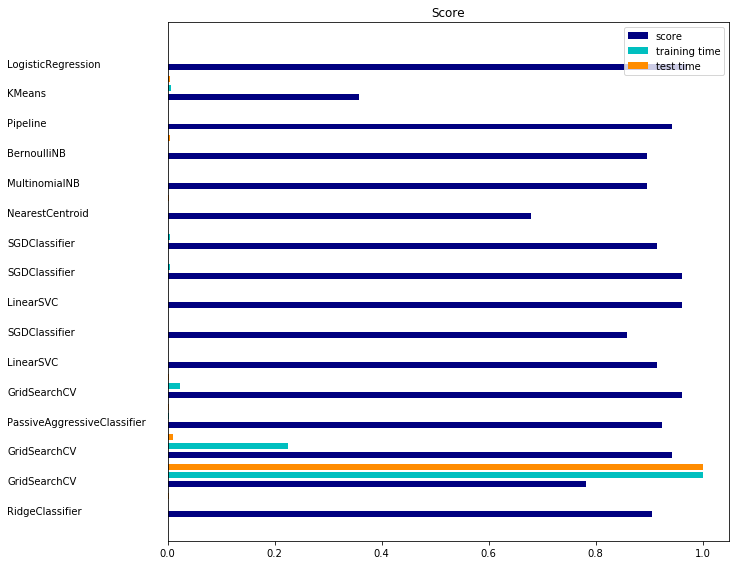

In [201]:
import matplotlib.pyplot as plt
for i_s, split in enumerate(range(1)):
    print("Evaluating Split {}".format(i_s))
    X_train, y_train, X_test, y_test, feature_names = data_for_training()
    #target_names = ["Make Update", "Setup Printer", "Shutdown Computer","Software Recommendation", "None"]
    target_names = ["Download Video", "Change Password", "None", "Export Data", "Sync Accounts",
                  "Filter Spam", "Find Alternative", "Delete Account"]
    print("Train Size: {}\nTest Size: {}".format(X_train.shape[0], X_test.shape[0]))
    results = []
    #alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
    parameters_mlp={'hidden_layer_sizes':[(100,50), (300, 100),(300,200,100)]}
    parameters_RF={ "n_estimators" : [50,60,70],
           "min_samples_leaf" : [1, 11]}
    k_range = list(range(3,7))
    parameters_knn = {'n_neighbors':k_range}
    knn=KNeighborsClassifier(n_neighbors=5)
    for clf, name in [  
            (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
            (GridSearchCV(knn,parameters_knn, cv=5),"gridsearchknn"),
            #(Perceptron(n_iter=50), "Perceptron"),
            (GridSearchCV(MLPClassifier(activation='tanh'),parameters_mlp, cv=5),"gridsearchmlp"),
           # (MLPClassifier(hidden_layer_sizes=(100, 50), activation="logistic", max_iter=300), "MLP"),
            #(MLPClassifier(hidden_layer_sizes=(300, 100, 50), activation="logistic", max_iter=500), "MLP"),
           # (MLPClassifier(hidden_layer_sizes=(300, 100, 50), activation="tanh", max_iter=500), "MLP"),
            (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
           # (KNeighborsClassifier(n_neighbors=1), "kNN"),
           # (KNeighborsClassifier(n_neighbors=3), "kNN"),
           # (KNeighborsClassifier(n_neighbors=5), "kNN"),
            #(KNeighborsClassifier(n_neighbors=10), "kNN"),
            (GridSearchCV(RandomForestClassifier(n_estimators=10),parameters_RF, cv=5),"gridsearchRF")
            #(RandomForestClassifier(n_estimators=10), "Random forest"),
            #(RandomForestClassifier(n_estimators=50), "Random forest")
    ]:
           
        print('=' * 80)
        print(name)
        results.append(benchmark(clf, X_train, y_train, X_test, y_test, target_names,
                                 feature_names=feature_names))
       # print('parameters')
       # print(clf.grid_scores_[0])
        #print('CV Validation Score')
       # print(clf.grid_scores_[0].cv_validation_scores)
       # print('Mean Validation Score')
       # print(clf.grid_scores_[0].mean_validation_score)
       # grid_mean_scores = [result.mean_validation_score for result in clf.grid_scores_]
       # print(grid_mean_scores)
       # plt.plot(k_range, grid_mean_scores)
       # plt.xlabel('Value of K for KNN')
       # plt.ylabel('Cross-Validated Accuracy')

    #parameters_Linearsvc = [{'C': [1, 10], 'gamma': [0.1,1.0]}]
    for penalty in ["l2", "l1"]:
        print('=' * 80)
        print("%s penalty" % penalty.upper())
        # Train Liblinear model
        #grid=(GridSearchCV(LinearSVC,parameters_Linearsvc, cv=10),"gridsearchSVC")
        #results.append(benchmark(LinearSVC(penalty=penalty), X_train, y_train, X_test, y_test, target_names,
                                # feature_names=feature_names))
        results.append(benchmark(LinearSVC(penalty=penalty, dual=False,tol=1e-3),
                                 X_train, y_train, X_test, y_test, target_names,
                                 feature_names=feature_names))

        # Train SGD model
        results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                               penalty=penalty),
                                 X_train, y_train, X_test, y_test, target_names,
                                 feature_names=feature_names))

    # Train SGD with Elastic Net penalty
    print('=' * 80)
    print("Elastic-Net penalty")
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty="elasticnet"),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))

    # Train NearestCentroid without threshold
    print('=' * 80)
    print("NearestCentroid (aka Rocchio classifier)")
    results.append(benchmark(NearestCentroid(),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))

    # Train sparse Naive Bayes classifiers
    print('=' * 80)
    print("Naive Bayes")
    results.append(benchmark(MultinomialNB(alpha=.01),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))
    results.append(benchmark(BernoulliNB(alpha=.01),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))

    print('=' * 80)
    print("LinearSVC with L1-based feature selection")
    # The smaller C, the stronger the regularization.
    # The more regularization, the more sparsity.
    
# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
    results.append(benchmark(Pipeline([
                                  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                                                  tol=1e-3))),
                                  ('classification', LinearSVC(penalty="l2"))]),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))
   # print(grid.grid_scores_)
   #KMeans clustering algorithm 
    print('=' * 80)
    print("KMeans")
    results.append(benchmark(KMeans(n_clusters=2, init='k-means++', max_iter=300,
                verbose=0, random_state=0, tol=1e-4),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))
    
   
    
    print('=' * 80)
    print("LogisticRegression")
    #kfold = model_selection.KFold(n_splits=2, random_state=0)
    #model = LinearDiscriminantAnalysis()
    results.append(benchmark(LogisticRegression(C=1.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))
    
    plot_results(results)
    
    

In [179]:
print(len(X_train))

779
